<a href="https://colab.research.google.com/github/sarah2234/CBNU_ArtificialIntelligence/blob/main/EmotionRecognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Input
from tensorflow.keras.callbacks import EarlyStopping
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/

!unzip -qq "/content/drive/MyDrive/Colab Notebooks/FER-2013.zip"

/content/drive/MyDrive/Colab Notebooks


## 예시 이미지 화면에 띄우기

In [3]:
img_array = cv2.imread("/content/drive/MyDrive/Colab Notebooks/FER-2013/train/angry/Training_34758750.jpg") # no korean in path

In [4]:
img_array.shape # rgb

(48, 48, 3)

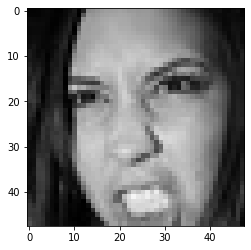

In [5]:
plt.imshow(img_array) # bgr

In [6]:
classes = ["angry", "happy", "neutral", "sad", "surprise"] # list of classes(exact name of folders)

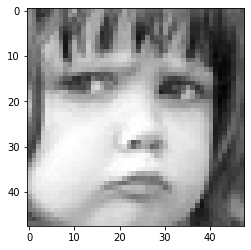

In [7]:
for category in classes:
    path = os.path.join("/content/drive/MyDrive/Colab Notebooks/FER-2013/train", category)
    for img in os.listdir(path): # os.listdir: 지정한 디렉토리 내 모든 파일과 디렉토리의 리스트 반환
        img_array = cv2.imread(os.path.join(path, img))
        plt.imshow(cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB))
        plt.show()
        break
    break

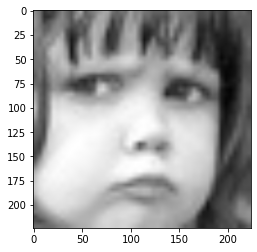

In [8]:
img_size = 224 # ImageNet => 224 x 224 (typical image size for computer vision tasks)
# 세션 다운 문제로 48 x 48
new_array = cv2.resize(img_array, (img_size, img_size))
plt.imshow(cv2.cvtColor(new_array, cv2.COLOR_BGR2RGB))
plt.show()

In [9]:
new_array.shape

(224, 224, 3)

# Read all the images and converting them to array

In [10]:
training_data = []
validation_data = []

def create_training_data():
    for category in classes:
        path = os.path.join("/content/drive/MyDrive/Colab Notebooks/FER-2013/train", category)
        class_num = classes.index(category)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img))
                new_array = cv2.resize(img_array, (img_size, img_size))
                training_data.append([new_array, class_num])
            except exception as e:
                pass

def create_validation_data():
  for category in classes:
    path = os.path.join("/content/drive/MyDrive/Colab Notebooks/FER-2013/val", category)
    class_num = classes.index(category)
    for img in os.listdir(path):
      try:
        img_array = cv2.imread(os.path.join(path, img))
        new_array = cv2.resize(img_array, (img_size, img_size))
        validation_data.append([new_array, class_num])
      except exception as e:
          pass

create_training_data()
create_validation_data()

In [11]:
print(len(training_data))

2500


In [12]:
temp = np.array(training_data, dtype=object) # numpy 배열 생성

In [13]:
temp.shape # 각 차원의 크기를 tuple로 표시

(2500, 2)

In [14]:
import random

random.shuffle(training_data) 
random.shuffle(validation_data)
# epoch마다 데이터를 랜덤하게 섞는 이유: 
# 데이터를 학습하는 과정에서 해당 데이터의 순서에 의존하지 않고 임의의 데이터가 입력되는 것으로 간주하기 위해서

In [15]:
x_training = [] # data (feature)
y_training = [] # label

x_validation = []
y_validation = []

for features, label in training_data:
    x_training.append(features)
    y_training.append(label)

for features, label in validation_data:
    x_validation.append(features)
    y_validation.append(label)
    
X_training = np.array(x_training).reshape(-1, img_size, img_size, 3); # converting it to 4 dimension
X_validation = np.array(x_validation).reshape(-1, img_size, img_size, 3);

In [16]:
X_training.shape

(2500, 224, 224, 3)

In [17]:
# normalize the data
#X = X / 225.0;
X_training = X_training / 225.0;
X_validation = X_validation / 225.0;

In [18]:
type(y_training)

list

In [19]:
Y_training = np.array(y_training)
Y_validation = np.array(y_validation)

In [20]:
Y_training.shape

(2500,)

# deep learning model for training - Transfer Learning

In [21]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, Dense, ReLU, Softmax, BatchNormalization, DepthwiseConv2D, ZeroPadding2D, GlobalAveragePooling2D, add, Dropout

In [22]:
mobileNetV2 = tf.keras.applications.MobileNetV2();
mobileNetV2.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

# Transfer Learning - Tuning, weights will start from last check point

In [23]:
base_input = mobileNetV2.layers[0].input # 첫 번째 layer -> input_2 (InputLayer)
#base_input = layers.Input(shape=(48,48,3))

In [24]:
base_input

<KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'input_1')>

In [25]:
base_output = mobileNetV2.layers[-2].output # 마지막에서 두 번째 layer -> global_average_pooling2d_1 (GlobalAveragePooling2D)

In [26]:
base_output

<KerasTensor: shape=(None, 1280) dtype=float32 (created by layer 'global_average_pooling2d')>

tk.keras.layers.Dense: 신경망을 만듦. input을 넣었을 때 output으로 바꿔주는 중간 다리

* units(정수): 출력값의 크기

* ouput = tf.keras.layers.Dense(units, ...)(input) / units: 출력값의 크기

* tf.keras.layers.Activation('relu') / relu: rectifier 함수, 주로 은닉층에 쓰임

* softmax: 소프트맥스 함수, 다중 클래스 분류 문제에서 출력층에 주로 쓰임

신경망: input -> activation function -> hidden -> activation function -> output

y = f(Wa+b)   
f(): 활성화 함수(딥러닝 네트워크에서 노드에 입력된 값들을 비선형 함수에 통과시킨 후 다음 레이어로 전달할 때 사용, sigmoid/tanh/relu...)   
W: 가중치   
x: input data    
y: output data   

https://han-py.tistory.com/207

In [27]:
final_output = layers.Dense(128)(base_output) # adding new layer, after the output of global pooling layer
final_output = layers.Activation('relu')(final_output) # activation function
final_output = layers.Dense(64)(final_output)
final_output = layers.Activation('relu')(final_output)
final_output = layers.Dense(5, activation='softmax')(final_output) # output: 5 (5-class emotion)

In [28]:
final_output # output

<KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'dense_2')>

In [29]:
new_model = keras.Model(inputs = base_input, outputs = final_output) # 기존 model: output이 1000개였으나 new_model에서는 감정 개수에 따라 5개로 줄임

In [30]:
new_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

In [31]:
new_model.compile(loss="sparse_categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"])

In [70]:
#Y[7000]

In [32]:
 new_result=new_model.fit(X_training, Y_training, epochs = 60, validation_data=(X_validation, Y_validation), batch_size=32, shuffle=True)

Epoch 1/60
79/79 [==============================] - 554s 7s/step - loss: 1.2003 - accuracy: 0.5156 - val_loss: 3.9461 - val_accuracy: 0.2976
Epoch 2/60
79/79 [==============================] - 535s 7s/step - loss: 0.9078 - accuracy: 0.6608 - val_loss: 3.3921 - val_accuracy: 0.3747
Epoch 3/60
79/79 [==============================] - 545s 7s/step - loss: 0.7497 - accuracy: 0.7148 - val_loss: 7.6430 - val_accuracy: 0.2000
Epoch 4/60
79/79 [==============================] - 541s 7s/step - loss: 0.7225 - accuracy: 0.7256 - val_loss: 5.4283 - val_accuracy: 0.3964
Epoch 5/60
79/79 [==============================] - 558s 7s/step - loss: 0.5631 - accuracy: 0.7884 - val_loss: 5.3412 - val_accuracy: 0.4157
Epoch 6/60
79/79 [==============================] - 542s 7s/step - loss: 0.5251 - accuracy: 0.8124 - val_loss: 14.1526 - val_accuracy: 0.2024
Epoch 7/60
79/79 [==============================] - 535s 7s/step - loss: 0.4171 - accuracy: 0.8476 - val_loss: 4.9774 - val_accuracy: 0.3904
Epoch 8/60
7

KeyboardInterrupt: ignored

In [33]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(new_result.history['acc'])
plt.plot(new_result.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(new_result.history['loss'])
plt.plot(new_result.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

NameError: ignored

In [ ]:
new_model.save('mod_my_model_94p69.h5')

In [ ]:
# 뭔 소리야!!!

In [ ]:
#model = tf.keras.applications.MobileNetV2() # Pre - trained model

#### MobileNetV2 모델 새로 만들기
# model = tf.keras.models.Sequential()
# model.add(layers.Input(shape=(48,48,3)))
# model.add(layers.Conv2D(32, kernel_size=3, strides=(2, 2), padding='valid', use_bias=False, name='Conv1'));
# model.add(layers.BatchNormalization(name='bn_Conv1'))
# model.add(layers.ReLU(6, name='Conv1_relu'))
# model.add(layers.DepthwiseConv2D(kernel_size=3, strides=1, activation=None, use_bias=False, padding='same', name='expanded_conv_depthwise'))
# model.add(layers.BatchNormalization(axis=-1, epsilon=0.001, momentum=0.99, name='expanded_conv_depthwise_BN'))


# final_output = layers.Dense(128)(model.layers[-1].output) # adding new layer, after the output of global pooling layer
# final_output = layers.Activation('relu')(final_output) # activation function
# final_output = layers.Dense(64)(final_output)
# final_output = layers.Activation('relu')(final_output)
# final_output = layers.Dense(5, activation='softmax')(final_output) # output: 5 (5-class emotion)

# base_input = model.layers[0].input
# new_model = keras.Model(inputs = base_input, outputs = final_output)

#new_model.build()

# model = Sequential([
#     Conv2D(32, kernel_size=3, strides=(2, 2), padding='same', use_bias = False, input_shape=(48, 48, 3), name='Conv1'),
#     BatchNormalization(axis=-1, epsilon=0.001, momentum=0.99, name='bn_Conv1'),
#     ReLU(name='Conv2_relu'),
#     DepthwiseConv2D(kernel_size=3, name='expanded_conv_depthwise'),
#     BatchNormalization(name='expanded_conv_depthwise_BN'),
#     ReLU(max_value=6,name='expanded_conv_depthwise_relu'),
#     Conv2D(filters=32, kernel_size=3, strides=2, name='expanded_conv_project'),
#     BatchNormalization(name='expanded_conv_project_BN'),

#     Conv2D(filters=64, kernel_size=3, name='block_1_expand'),
#     BatchNormalization(name='block_1_expand_BN'),
#     ReLU(name='block_1_expand_relu'),
#     ZeroPadding2D(name='block_1_pad'),
#     DepthwiseConv2D(kernel_size=3, name='block_1_depthwise'),
#     BatchNormalization(name='block_1_depthwise_BN'),
#     ReLU(name='block_1_depthwise_relu'), 
#     Conv2D(filters=64, kernel_size=3, name='block_1_project'),
#     BatchNormalization(name='block_1_project_BN'),

#     Conv2D(filters=128, kernel_size=3, name='block_2_expand'),
#     BatchNormalization(name='block_2_expand_BN'),
#     ReLU(name='block_2_expand_relu'),
#     DepthwiseConv2D(kernel_size=3, name='block_2_depthwise'),
#     BatchNormalization(name='block_2_depthwise_BN'),
#     ReLU(name='block_2_depthwise_relu'),
#     Conv2D(filters=128, kernel_size=3, name='block_2_project'),
#     BatchNormalization(name='block_2_project_BN'),
#     Add(name='block_2_add'),

#     Conv2D(filters=128, kernel_size=3, name='block_3_expand'),
#     BatchNormalization(name='block_3_expand_BN'),
#     ReLU(name='block_3_expand_relu'),
#     ZeroPadding2D(name='block_3_pad'),
#     DepthwiseConv2D(kernel_size=3, name='block_3_depthwise'),
#     BatchNormalization(name='block_3_depthwise_BN'),
#     ReLU(name='block_3_depthwise_relu'),
#     Conv2D(filters=128, kernel_size=3, name='block_3_project'),
#     BatchNormalization(name='block_3_project_BN'),

#     Conv2D(filters=256, kernel_size=3, name='Conv_1'),
#     BatchNormalization(name='Conv_1_bn'),
#     ReLU(name='out_relu'),
#     GlobalAveragePooling2D(name='global_average_pooling2d'),
#     Dense(128, name='final_layer_1'),
#     ReLU(name='final_layer_2'),
#     Dense(64, name='final_layer_3'),
#     ReLU(name='final_layer_4'),
#     Dense(5, activation='softmax', name='predictions') # 5-class emotion
#     ])

def expansion_block(x,t,filters,block_id):
    prefix = 'block_{}_'.format(block_id)
    total_filters = t*filters
    x = Conv2D(total_filters,1,padding='same',use_bias=False, name =    prefix +'expand')(x)
    x = BatchNormalization(name=prefix +'expand_bn')(x)
    x = ReLU(6,name = prefix +'expand_relu')(x)
    return x
def depthwise_block(x,stride,block_id):
    prefix = 'block_{}_'.format(block_id)
    x = DepthwiseConv2D(3,strides=(stride,stride),padding ='same', use_bias = False, name = prefix + 'depthwise_conv')(x)
    x = BatchNormalization(name=prefix +'dw_bn')(x)
    x = ReLU(6,name = prefix +'dw_relu')(x)
    return x
def projection_block(x,out_channels,block_id):
    prefix = 'block_{}_'.format(block_id)
    x = Conv2D(filters=out_channels,kernel_size = 1,   padding='same',use_bias=False,name= prefix + 'compress')(x)
    x = BatchNormalization(name=prefix +'compress_bn')(x)
    return x

def Bottleneck(x,t,filters, out_channels,stride,block_id):
    y = expansion_block(x,t,filters,block_id)
    y = depthwise_block(y,stride,block_id)
    y = projection_block(y, out_channels,block_id)
    if y.shape[-1]==x.shape[-1]:
       y = add([x,y])
    return y

def MobileNetV2(input_shape = (224,224,3), n_classes=5):
    input = Input (input_shape)
    x = Conv2D(32,3,strides=(2,2),padding='same', use_bias=False)(input)
    x = BatchNormalization(name='conv1_bn')(x)
    x = ReLU(6, name='conv1_relu')(x)
    # 17 Bottlenecks
    x = depthwise_block(x,stride=1,block_id=1)
    x = projection_block(x, out_channels=16,block_id=1)
    x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 24, stride = 2,block_id = 2)
    x = Dropout(rate=0.3)(x)
    x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 24, stride = 1,block_id = 3)
    x = Dropout(rate=0.3)(x)
    x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 32, stride = 2,block_id = 4)
    x = Dropout(rate=0.3)(x)
    x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 32, stride = 1,block_id = 5)
    x = Dropout(rate=0.3)(x)
    x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 32, stride = 1,block_id = 6)
    x = Dropout(rate=0.3)(x)
    x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 64, stride = 2,block_id = 7)
    x = Dropout(rate=0.3)(x)
    x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 64, stride = 1,block_id = 8)
    x = Dropout(rate=0.3)(x)
    x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 64, stride = 1,block_id = 9)
    x = Dropout(rate=0.3)(x)
    x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 64, stride = 1,block_id = 10)
    x = Dropout(rate=0.3)(x)
    x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 96, stride = 1,block_id = 11)
    x = Dropout(rate=0.3)(x)
    x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 96, stride = 1,block_id = 12)
    x = Dropout(rate=0.3)(x)
    x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 96, stride = 1,block_id = 13)
    x = Dropout(rate=0.3)(x)
    x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 160, stride = 2,block_id = 14)
    x = Dropout(rate=0.3)(x)
    x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 160, stride = 1,block_id = 15)
    x = Dropout(rate=0.3)(x)
    x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 160, stride = 1,block_id = 16)
    x = Dropout(rate=0.3)(x)
    x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 320, stride = 1,block_id = 17)
    x = Dropout(rate=0.3)(x)
    x = Conv2D(filters = 1280,kernel_size = 1,padding='same',use_bias=False, name = 'last_conv')(x)
    x = BatchNormalization(name='last_bn')(x)
    x = ReLU(6,name='last_relu')(x)
    x = GlobalAveragePooling2D(name='global_average_pool')(x)
    output = Dense(n_classes,activation='softmax')(x)
    model = keras.Model(input, output)
    return model

model = MobileNetV2()
model.summary()

model.compile(loss="sparse_categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"])
result = model.fit(X_training, Y_training, validation_data=(X_validation, Y_validation), epochs=60, batch_size=32, shuffle=True)

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_4 (Conv2D)              (None, 112, 112, 32  864         ['input_7[0][0]']                
                                )                                                                 
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 112, 112, 32  128         ['conv2d_4[0][0]']               
                                )                                                           

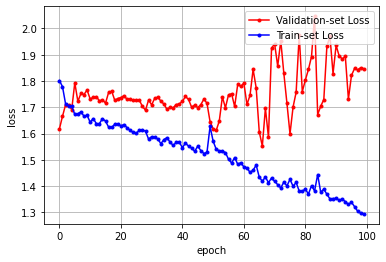

In [25]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(result.history['acc'])
plt.plot(result.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(result.history['loss'])
plt.plot(result.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()